Najpiwr import wszelakich bibliotek

In [62]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import seaborn as sns
from torch.utils.data import DataLoader, random_split, DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from tensorflow.keras import layers, models
import time
import random
import torchvision
import torchvision.transforms as transforms

Ładowanie zbioru danych:

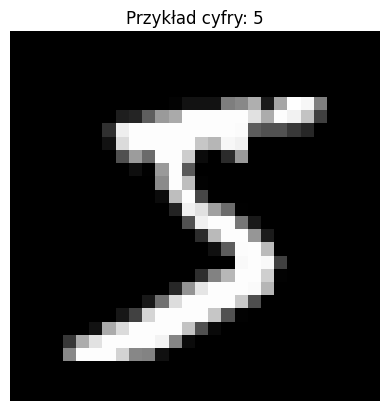

In [63]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


plt.imshow(x_train[0], cmap='gray')
plt.title(f"Przykład cyfry: {y_train[0]}")
plt.axis('off')
plt.show()

Przygotowanie danych - ze skali 0-255 do 0-1:

In [64]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]
print("Wymiar danych treningowych:", x_train.shape)

Wymiar danych treningowych: (60000, 28, 28, 1)


Stworzenie baseline'u - zwykłej gęstej sieci - MLP:
- przekształcenie obrazka w wektor 784
- użycie warstwy gęstej
- uzyskane wyjście jako cyfra od 0 do 9

In [65]:
baseline = models.Sequential([
    layers.Flatten(input_shape=(28, 28, 1)),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")])

baseline.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

baseline.fit(x_train, y_train, epochs=10, validation_split=0.1)

baseline.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8722 - loss: 0.4530 - val_accuracy: 0.9655 - val_loss: 0.1235
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9636 - loss: 0.1234 - val_accuracy: 0.9737 - val_loss: 0.0894
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9763 - loss: 0.0817 - val_accuracy: 0.9780 - val_loss: 0.0777
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9823 - loss: 0.0570 - val_accuracy: 0.9760 - val_loss: 0.0839
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9866 - loss: 0.0446 - val_accuracy: 0.9777 - val_loss: 0.0740
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9898 - loss: 0.0330 - val_accuracy: 0.9775 - val_loss: 0.0801
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9912 - loss: 0.0274 - val_accuracy: 0.9797 - val_loss: 0.0803
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9939 - loss: 0.0207

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_14 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,312 (1.16 MB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 203,542 (795.09 KB)

Wnioski po uruchomieniu sieci MPL:
- im dalsza epoka, tym większa dokładność oraz mniejsza strata - świetne wartości
- im więcej epok, tym dłużej proces cały zajmuje czasu (logiczne), ale model lepiej się uczy
- model dobrze sobie poradził z danymi oraz nie zaszedł overfitting

Teraz spróbuję sprawdzić sieć główną - CNN:

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 56s 31ms/step - accuracy: 0.8522 - loss: 0.4559 - val_accuracy: 0.9870 - val_loss: 0.0481
Epoch 2/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 78s 29ms/step - accuracy: 0.9725 - loss: 0.0953 - val_accuracy: 0.9895 - val_loss: 0.0426
Epoch 3/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 84s 30ms/step - accuracy: 0.9798 - loss: 0.0702 - val_accuracy: 0.9898 - val_loss: 0.0381
Epoch 4/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 80s 29ms/step - accuracy: 0.9838 - loss: 0.0514 - val_accuracy: 0.9890 - val_loss: 0.0422
Epoch 5/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 81s 28ms/step - accuracy: 0.9868 - loss: 0.0448 - val_accuracy: 0.9895 - val_loss: 0.0404
Epoch 6/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.9885 - loss: 0.0372 - val_accuracy: 0.9902 - val_loss: 0.0386
Epoch 7/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.9891 - loss: 0.0365 - val_accuracy: 0.9882 - val_loss: 0.0480
Epoch 8/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 81s 28ms/step - accuracy: 0.9911 -

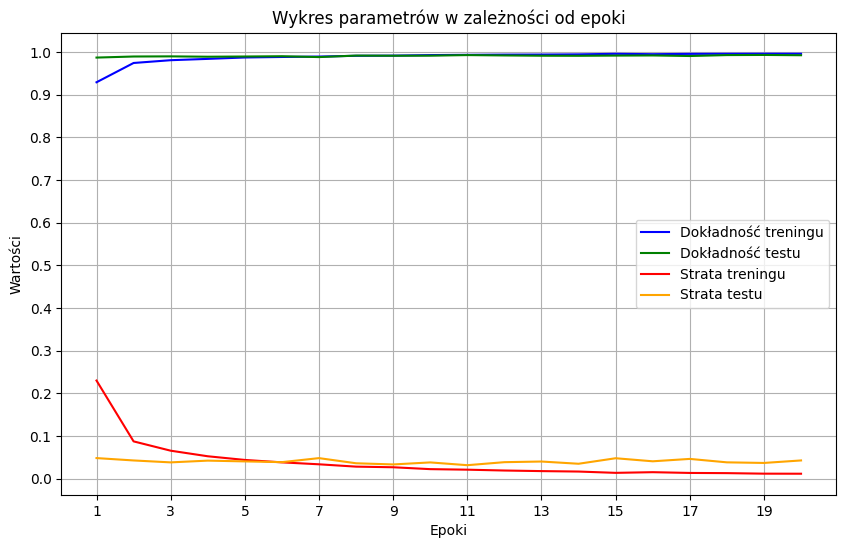

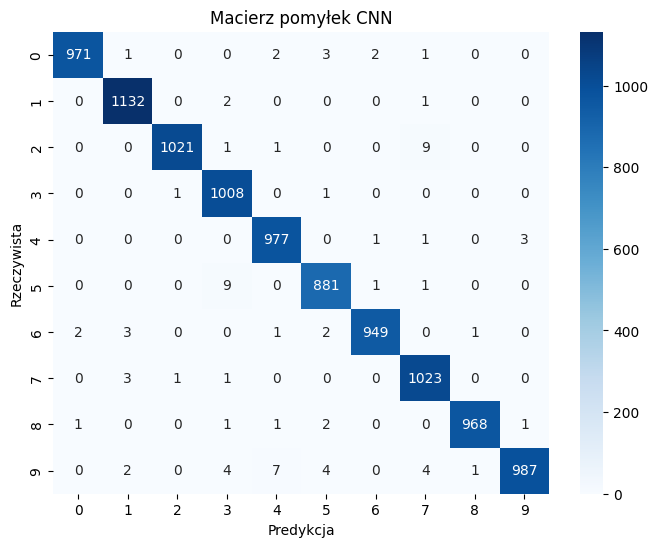

In [66]:
cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")])

cnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = cnn.fit(x_train, y_train, epochs=20, validation_split=0.1)

test_loss, test_acc = cnn.evaluate(x_test, y_test, verbose=0)
print("Dokładność na testowych danych:", round(test_acc*100,2), "%")

y_pred = cnn.predict(x_test).argmax(axis=1)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss  = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(10,6))
plt.plot(epochs, acc, 'b-', label='Dokładność treningu')
plt.plot(epochs, val_acc, 'g-', label='Dokładność testu')
plt.plot(epochs, loss, 'r-', label='Strata treningu')
plt.plot(epochs, val_loss, 'orange', label='Strata testu')
plt.xticks(range(1, len(acc)+1, 2))
plt.yticks(np.arange(0, max(max(acc), max(val_acc), max(loss), max(val_loss)) + 0.1, 0.1))
plt.title("Wykres parametrów w zależności od epoki")
plt.xlabel("Epoki")
plt.ylabel("Wartości")
plt.legend()
plt.grid(True)
plt.show()

print()
print()

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predykcja")
plt.ylabel("Rzeczywista")
plt.title("Macierz pomyłek CNN")
plt.show()

Wnioski:
- 5 przejść już długo zajęło - parę minut a 20 epok z 25 minut
- dokładność modelu jest bardzo wysoka (99,66%)
- jest bardzo mała strata (0,97%)
- model bardzo dobrze poradził sobie - nie ma overfittingu
- precyzja, recall i f1 są na poziomie 0.99 lub 1, czyli praktycznie idealnie - model dobrze rozpoznaje cyfry
- z wykresu macierzowego widać, że model tylko pojedyncze przypadki pomylił

A teraz sieci z wykorzystaniem funkcji:

Przygotowanie danych:

In [67]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


Zdefiniowanie sieci

In [68]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

Stworzenie:

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Trenowanie:

In [70]:
for epoch in range(10):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoka [", epoch+1, "/ 10 ];", "loss:", round(loss.item()*100,2), "%")

Epoka [ 1 / 10 ]; loss: 6.01 %
Epoka [ 2 / 10 ]; loss: 10.02 %
Epoka [ 3 / 10 ]; loss: 23.74 %
Epoka [ 4 / 10 ]; loss: 15.16 %
Epoka [ 5 / 10 ]; loss: 4.9 %
Epoka [ 6 / 10 ]; loss: 4.49 %
Epoka [ 7 / 10 ]; loss: 1.2 %
Epoka [ 8 / 10 ]; loss: 2.01 %
Epoka [ 9 / 10 ]; loss: 6.52 %
Epoka [ 10 / 10 ]; loss: 0.73 %


Ewolucja:

In [71]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Dokładność:", 100*correct/total, "%")


Dokładność: 97.52 %


Jak widać, model też ładnie sobie poradził - strata bardzo niska a dokładność wyników wysoka bardzo. Na różne sposoby można tworzyć sieci neuronowe

Częściowo wspomagałem się ai, gdyż były to dla mnie całkowicie nowe rzeczy, ale dużo się dowiedziałem. Sorki, ale mało czasu miałem, więc mogą być jakieś nieprawidłowości. Adam jest pomocny haha :))